# Adaption to new classes
project 7 by Guanzhao Wang, Haochen Wu, Yukai Wang

### Abstact outline:
In this project, the goal is to find a way conbines unsupervised and supervised method. 

A classification model is trained under labelled categories on Fashion-MNIST dataset. Then, new categories are added without labels. There are several unsupervised clustering methods implemented and compared. The classification model will based on the pretrained model from supervised images and retrained with the categories labelled by the unsupervised methods.

### Teammates:
- Guanzhao Wang:

- Haochen Wu:

- Yukai Wang:

In [1]:
from mylibs.dataloader import getTrainValidateLoaders, getTestLoaders
from mylibs.train import train
from mylibs.eval import validate
from mylibs.model import Net, CustomFashionResNet
from mylibs.loss import loss_function
from mylibs.report import report_epoch_summary, report_summary
from mylibs.save import save, load

import torch
from torchvision import transforms
import os

In [2]:
USE_GPU = True
BATCH_SIZE = 64
EPOCH = 50
NUM_WORKERS = 2
K = 7

In [3]:
device = torch.device("cuda" if USE_GPU else "cpu")

transform = transforms.Compose([
    transforms.ToTensor()
])

mode_description = {0: "clustering: kmeans",
                    1: "clustering: kmeans with PCA",
                    2: "clustering: kmeans with Auto Encoder",
                    3: "clustering: Gaussian Mixture",
                    4: "clustering: Gaussian Mixture with PCA",
                    5: "clustering: Gaussian Mixture with Auto Encoder",
                    6: "use only labeled data",
                    7: "use full FasionMNIST data",
                   }

mode_description_short = {0: "Kmeans",
                          1: "Kmeans with PCA",
                          2: "Kmeans with Auto Encoder",
                          3: "Gaussian Mixture",
                          4: "Gaussian Mixture with PCA",
                          5: "Gaussian Mixture with Auto Encoder",
                          6: "Labeled data only",
                          7: "Full FasionMNIST",
                         }

mode_metrics = {}

In [4]:
def whole_flow(mode, useResnet):
    print(f"Getting train and validate dataloaders for mode {mode}: {mode_description[mode]}")
    train_val_loaders = getTrainValidateLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, split=0.9, num_workers=NUM_WORKERS, mode=mode, USE_GPU=USE_GPU)
    if useResnet:
        model = CustomFashionResNet(color_scale = 1, num_classes = 10).to(device)
    else:
        model = Net().to(device)
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)
    eval_metrics = []

    model_name = "ResNet" if useResnet else "Net"
    checkpoint_path = f"./checkpoint/mode_{mode}/{model_name}"
    os.makedirs(checkpoint_path, exist_ok=True)
    
    print(f"Start Training... {model_name}")
    # scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, EPOCH+1):
        eval_metric = train(train_val_loaders, model, loss_function, optimizer, USE_GPU, f"{checkpoint_path}/epoch_{epoch}.pt")
        eval_metrics.append(eval_metric)
        print(f"Epoch: {epoch}")
        print(f"\tTrain      - Loss: {eval_metric['train']['loss']:.4f} Accuracy: {eval_metric['train']['acc']:.4f} F1_score: {eval_metric['train']['f1']:.4f}")
        print(f"\tValidation - Loss: {eval_metric['val']['loss']:.4f} Accuracy: {eval_metric['val']['acc']:.4f} F1_score: {eval_metric['val']['f1']:.4f}")

    report_epoch_summary(eval_metrics)
    
    all_val_f1 = [x['val']['f1'] for x in eval_metrics]
    best_epoch = all_val_f1.index(max(all_val_f1)) + 1
    print(f"Loading model at epoch {best_epoch} for best validation f1")
    checkpoint = torch.load(f"{checkpoint_path}/epoch_{epoch}.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print("Preparing test loaders")
    labeled_test_loader, unlabeled_test_loader, test_loader = getTestLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, USE_GPU=USE_GPU)
    
    model.eval()
    eval_metric = validate(labeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on labelled test set  : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(unlabeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on unlabelled test set: Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(test_loader, model, loss_function, USE_GPU)
    print(f"Result on full test set      : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")
    
    return eval_metrics

## Baseline #1, use only first K-class labelled data to train

Getting train and validate dataloaders for mode 6: use only labeled data
Start Training... Net
Epoch: 1
	Train      - Loss: 0.6038 Accuracy: 0.7898 F1_score: 0.7872
	Validation - Loss: 0.4646 Accuracy: 0.8257 F1_score: 0.8259
Epoch: 2
	Train      - Loss: 0.4150 Accuracy: 0.8502 F1_score: 0.8492
	Validation - Loss: 0.4082 Accuracy: 0.8536 F1_score: 0.8514
Epoch: 3
	Train      - Loss: 0.3695 Accuracy: 0.8664 F1_score: 0.8657
	Validation - Loss: 0.3913 Accuracy: 0.8605 F1_score: 0.8621
Epoch: 4
	Train      - Loss: 0.3406 Accuracy: 0.8772 F1_score: 0.8766
	Validation - Loss: 0.3638 Accuracy: 0.8702 F1_score: 0.8699
Epoch: 5
	Train      - Loss: 0.3192 Accuracy: 0.8859 F1_score: 0.8854
	Validation - Loss: 0.3539 Accuracy: 0.8729 F1_score: 0.8729
Epoch: 6
	Train      - Loss: 0.3023 Accuracy: 0.8918 F1_score: 0.8913
	Validation - Loss: 0.3462 Accuracy: 0.8748 F1_score: 0.8735
Epoch: 7
	Train      - Loss: 0.2888 Accuracy: 0.8969 F1_score: 0.8965
	Validation - Loss: 0.3381 Accuracy: 0.8776 F1_sc

<Figure size 432x288 with 0 Axes>

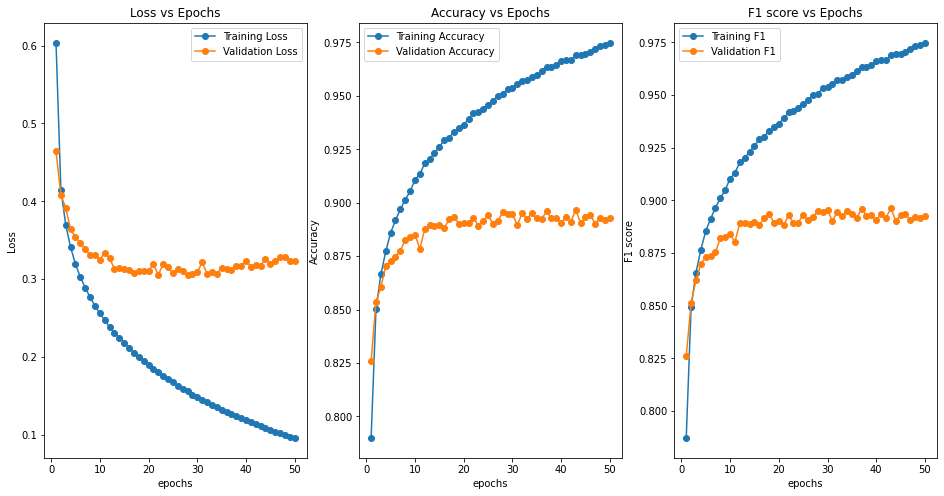

Loading model at epoch 43 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3304 Accuracy: 0.8914 F1_score: 0.8910
Result on unlabelled test set: Loss: 10.3998 Accuracy: 0.0000 F1_score: 0.0000
Result on full test set      : Loss: 3.3493 Accuracy: 0.6240 F1_score: 0.5389


In [5]:
mode_metric = whole_flow(6, False)
mode_metrics[6] = mode_metric

## Baseline #2, use full Fashion-MNIST dataset to train

Getting train and validate dataloaders for mode 7: use full FasionMNIST data
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5449 Accuracy: 0.8177 F1_score: 0.8155
	Validation - Loss: 0.3880 Accuracy: 0.8623 F1_score: 0.8613
Epoch: 2
	Train      - Loss: 0.3514 Accuracy: 0.8787 F1_score: 0.8779
	Validation - Loss: 0.3398 Accuracy: 0.8768 F1_score: 0.8755
Epoch: 3
	Train      - Loss: 0.3089 Accuracy: 0.8938 F1_score: 0.8932
	Validation - Loss: 0.3155 Accuracy: 0.8867 F1_score: 0.8868
Epoch: 4
	Train      - Loss: 0.2823 Accuracy: 0.9028 F1_score: 0.9023
	Validation - Loss: 0.2986 Accuracy: 0.8923 F1_score: 0.8917
Epoch: 5
	Train      - Loss: 0.2631 Accuracy: 0.9096 F1_score: 0.9092
	Validation - Loss: 0.2888 Accuracy: 0.8957 F1_score: 0.8944
Epoch: 6
	Train      - Loss: 0.2477 Accuracy: 0.9149 F1_score: 0.9146
	Validation - Loss: 0.2809 Accuracy: 0.8987 F1_score: 0.8991
Epoch: 7
	Train      - Loss: 0.2346 Accuracy: 0.9203 F1_score: 0.9200
	Validation - Loss: 0.2730 Accuracy: 0.9035 F

<Figure size 432x288 with 0 Axes>

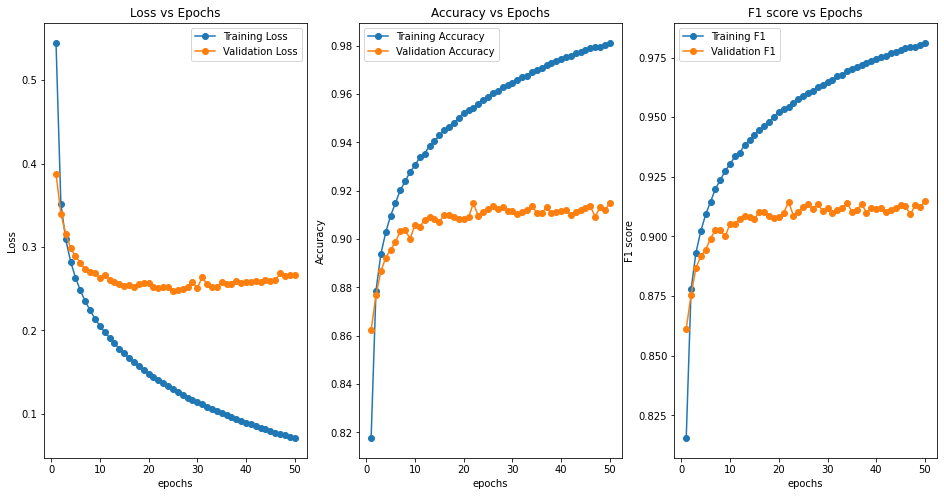

Loading model at epoch 50 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3536 Accuracy: 0.8839 F1_score: 0.8866
Result on unlabelled test set: Loss: 0.1064 Accuracy: 0.9673 F1_score: 0.9736
Result on full test set      : Loss: 0.2800 Accuracy: 0.9089 F1_score: 0.9085


In [6]:
mode_metric = whole_flow(7, False)
mode_metrics[7] = mode_metric

# Label new categories by clustering

- label the dataset under different clustering methods
- compare acuracy on the test set

## Approach #1, use KMeans to compute label for unlabelled data

Getting train and validate dataloaders for mode 0: clustering: kmeans
Labeling unlabeled data...
Labeling accuracy: 0.8801111111111111
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5461 Accuracy: 0.8183 F1_score: 0.8166
	Validation - Loss: 0.3913 Accuracy: 0.8630 F1_score: 0.8621
Epoch: 2
	Train      - Loss: 0.3637 Accuracy: 0.8730 F1_score: 0.8721
	Validation - Loss: 0.3416 Accuracy: 0.8815 F1_score: 0.8804
Epoch: 3
	Train      - Loss: 0.3213 Accuracy: 0.8879 F1_score: 0.8872
	Validation - Loss: 0.3205 Accuracy: 0.8903 F1_score: 0.8897
Epoch: 4
	Train      - Loss: 0.2947 Accuracy: 0.8974 F1_score: 0.8969
	Validation - Loss: 0.3049 Accuracy: 0.8935 F1_score: 0.8917
Epoch: 5
	Train      - Loss: 0.2754 Accuracy: 0.9041 F1_score: 0.9036
	Validation - Loss: 0.2916 Accuracy: 0.8997 F1_score: 0.8984
Epoch: 6
	Train      - Loss: 0.2599 Accuracy: 0.9097 F1_score: 0.9092
	Validation - Loss: 0.2859 Accuracy: 0.9008 F1_score: 0.9002
Epoch: 7
	Train      - Loss: 0.2464 Accuracy: 0.9147 F1_s

<Figure size 432x288 with 0 Axes>

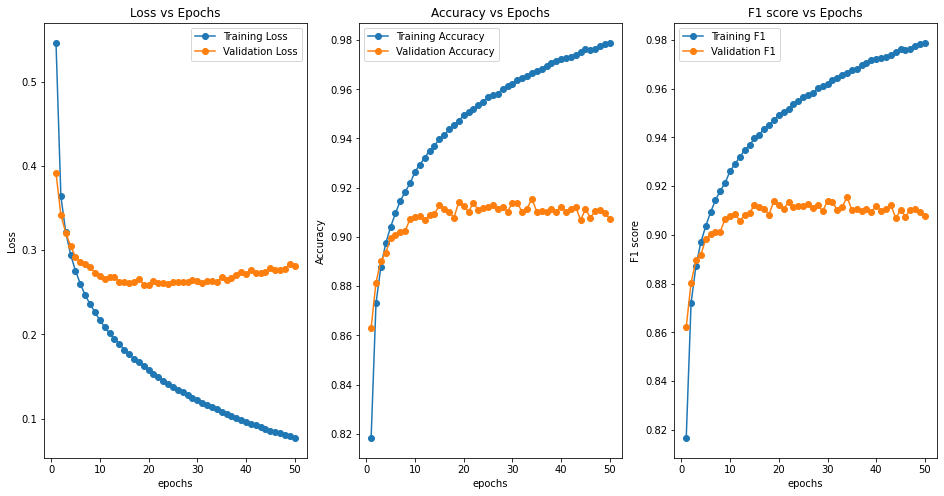

Loading model at epoch 34 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3663 Accuracy: 0.8773 F1_score: 0.8815
Result on unlabelled test set: Loss: 0.7718 Accuracy: 0.8793 F1_score: 0.8870
Result on full test set      : Loss: 0.4872 Accuracy: 0.8779 F1_score: 0.8790


In [7]:
mode_metric = whole_flow(0, False)
mode_metrics[0] = mode_metric

## Approach #2, use KMeans with PCA to compute label for unlabelled data

Getting train and validate dataloaders for mode 1: clustering: kmeans with PCA
Labeling unlabeled data...
Labeling accuracy: 0.8809444444444444
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5497 Accuracy: 0.8172 F1_score: 0.8154
	Validation - Loss: 0.4189 Accuracy: 0.8567 F1_score: 0.8576
Epoch: 2
	Train      - Loss: 0.3644 Accuracy: 0.8714 F1_score: 0.8706
	Validation - Loss: 0.3736 Accuracy: 0.8680 F1_score: 0.8689
Epoch: 3
	Train      - Loss: 0.3235 Accuracy: 0.8866 F1_score: 0.8861
	Validation - Loss: 0.3385 Accuracy: 0.8845 F1_score: 0.8839
Epoch: 4
	Train      - Loss: 0.2967 Accuracy: 0.8953 F1_score: 0.8948
	Validation - Loss: 0.3289 Accuracy: 0.8887 F1_score: 0.8889
Epoch: 5
	Train      - Loss: 0.2773 Accuracy: 0.9021 F1_score: 0.9016
	Validation - Loss: 0.3134 Accuracy: 0.8930 F1_score: 0.8931
Epoch: 6
	Train      - Loss: 0.2621 Accuracy: 0.9079 F1_score: 0.9076
	Validation - Loss: 0.3021 Accuracy: 0.8982 F1_score: 0.8980
Epoch: 7
	Train      - Loss: 0.2494 Accuracy: 0.

<Figure size 432x288 with 0 Axes>

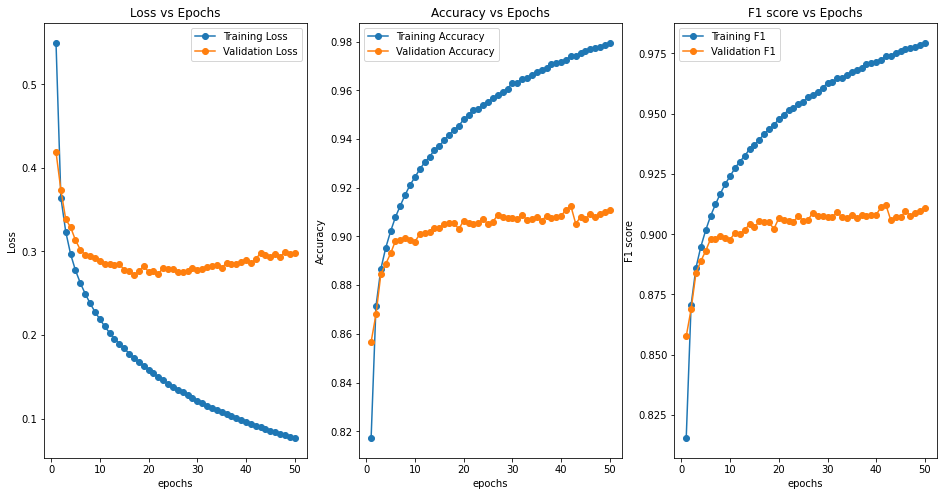

Loading model at epoch 42 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3707 Accuracy: 0.8843 F1_score: 0.8884
Result on unlabelled test set: Loss: 0.8325 Accuracy: 0.8713 F1_score: 0.8802
Result on full test set      : Loss: 0.5136 Accuracy: 0.8804 F1_score: 0.8813


In [16]:
mode_metric = whole_flow(1, False)
mode_metrics[1] = mode_metric

## Approach #3, use KMeans with Auto Encoder to compute label for unlabelled data

In [ ]:
mode_metric = whole_flow(2, False)
mode_metrics[2] = mode_metric

## Approach #4, use Gaussian Mixture to compute label for unlabelled data

Getting train and validate dataloaders for mode 3: clustering: Gaussian Mixture
Labeling unlabeled data...
Labeling accuracy: 0.8389444444444445
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5438 Accuracy: 0.8168 F1_score: 0.8147
	Validation - Loss: 0.4280 Accuracy: 0.8482 F1_score: 0.8451
Epoch: 2
	Train      - Loss: 0.3615 Accuracy: 0.8731 F1_score: 0.8724
	Validation - Loss: 0.3792 Accuracy: 0.8617 F1_score: 0.8601
Epoch: 3
	Train      - Loss: 0.3177 Accuracy: 0.8899 F1_score: 0.8894
	Validation - Loss: 0.3503 Accuracy: 0.8718 F1_score: 0.8700
Epoch: 4
	Train      - Loss: 0.2911 Accuracy: 0.8984 F1_score: 0.8979
	Validation - Loss: 0.3321 Accuracy: 0.8783 F1_score: 0.8780
Epoch: 5
	Train      - Loss: 0.2712 Accuracy: 0.9054 F1_score: 0.9051
	Validation - Loss: 0.3196 Accuracy: 0.8827 F1_score: 0.8820
Epoch: 6
	Train      - Loss: 0.2557 Accuracy: 0.9109 F1_score: 0.9105
	Validation - Loss: 0.3172 Accuracy: 0.8820 F1_score: 0.8806
Epoch: 7
	Train      - Loss: 0.2432 Accuracy: 0

<Figure size 432x288 with 0 Axes>

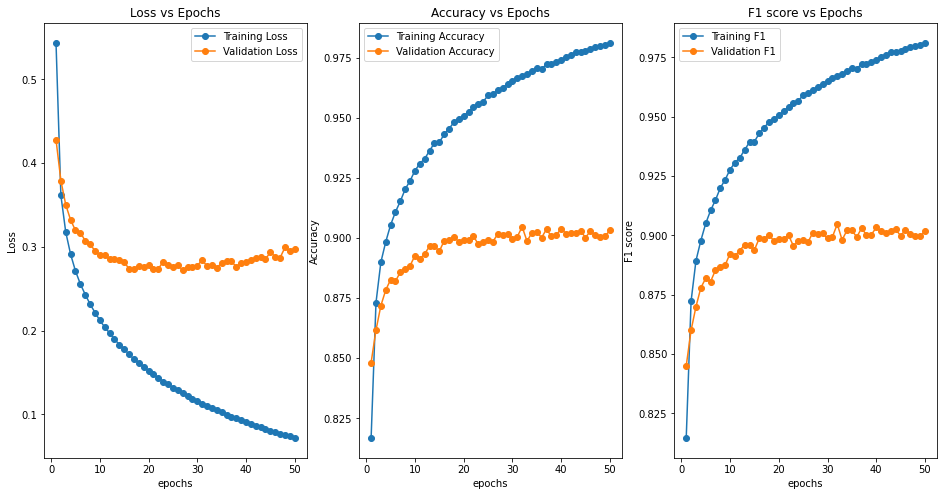

Loading model at epoch 32 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3766 Accuracy: 0.8754 F1_score: 0.8785
Result on unlabelled test set: Loss: 1.3815 Accuracy: 0.8303 F1_score: 0.8339
Result on full test set      : Loss: 0.6805 Accuracy: 0.8619 F1_score: 0.8603


In [9]:
mode_metric = whole_flow(3, False)
mode_metrics[3] = mode_metric

## Approach #5, use Gaussian Mixture with PCA to compute label for unlabelled data

Getting train and validate dataloaders for mode 4: clustering: Gaussian Mixture with PCA
Labeling unlabeled data...
Labeling accuracy: 0.6935555555555556
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5507 Accuracy: 0.8153 F1_score: 0.8132
	Validation - Loss: 0.4111 Accuracy: 0.8523 F1_score: 0.8480
Epoch: 2
	Train      - Loss: 0.3654 Accuracy: 0.8705 F1_score: 0.8696
	Validation - Loss: 0.3544 Accuracy: 0.8750 F1_score: 0.8743
Epoch: 3
	Train      - Loss: 0.3236 Accuracy: 0.8859 F1_score: 0.8854
	Validation - Loss: 0.3345 Accuracy: 0.8807 F1_score: 0.8807
Epoch: 4
	Train      - Loss: 0.2973 Accuracy: 0.8957 F1_score: 0.8952
	Validation - Loss: 0.3216 Accuracy: 0.8828 F1_score: 0.8812
Epoch: 5
	Train      - Loss: 0.2776 Accuracy: 0.9022 F1_score: 0.9018
	Validation - Loss: 0.3051 Accuracy: 0.8910 F1_score: 0.8902
Epoch: 6
	Train      - Loss: 0.2625 Accuracy: 0.9087 F1_score: 0.9083
	Validation - Loss: 0.3005 Accuracy: 0.8930 F1_score: 0.8932
Epoch: 7
	Train      - Loss: 0.2501 Ac

<Figure size 432x288 with 0 Axes>

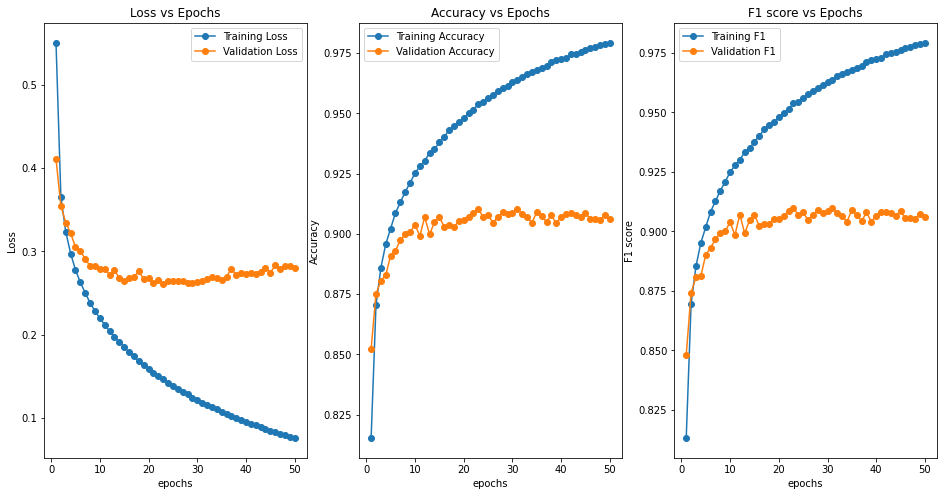

Loading model at epoch 31 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3505 Accuracy: 0.8826 F1_score: 0.8856
Result on unlabelled test set: Loss: 3.7333 Accuracy: 0.6980 F1_score: 0.6856
Result on full test set      : Loss: 1.3691 Accuracy: 0.8272 F1_score: 0.8226


In [10]:
mode_metric = whole_flow(4, False)
mode_metrics[4] = mode_metric

## Approach #6, use Gaussian Mixture with Auto Encoder to compute label for unlabelled data

In [ ]:
mode_metric = whole_flow(5, False)
mode_metrics[5] = mode_metric

<Figure size 432x288 with 0 Axes>

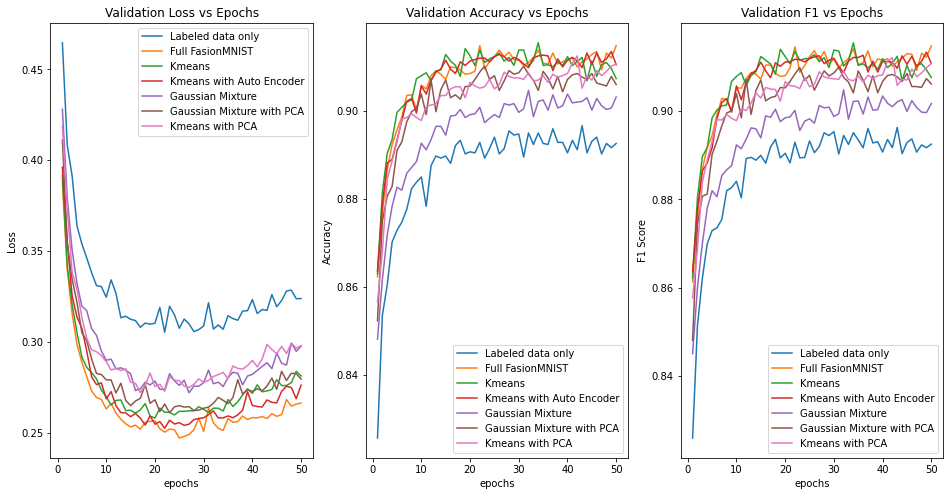

In [17]:
report_summary(mode_metrics, mode_description_short)

## Conclusion